In [1]:
import pandas as pd
import json
from py2neo import Graph, Node, Relationship
import networkx as nx

Metodos de definicion de clase objeto y tweet para hacer transparente el modelado

In [130]:

class user_class:
    def __init__(self, name, description, followers, following):
        self.name = name
        self.desc = description
        self.followers = followers
        self.following = following
        #print 'name:',name,'#desc:',description,'#followers:',followers,'#following:',following
    
class tweet_class:
    def __init__(self, name, autor, text, source, retweeted, publisher, polarity):
        self.identifier = name
        self.autor = autor
        self.text = text
        self.source = source
        self.retweeted = retweeted
        self.publisher = publisher
        self.polarity = polarity
        #print 'tweet:',name,'#autor:',autor,'#text:',text,'#polarity:',polarity
        

Creacion de grafo dentro de Neo4j

In [24]:
def create_node_user(user,graph):
    try:
        user_node = Node("User", id=str(user.name), desc=user.desc, followers=user.followers, following=user.following)
        graph.merge(user_node)
    except Exception as e:
        print e.args,':','creating user node graph'
        
    return user_node
    
def create_relationship(tweet,graph):
    #publish relationship when is retwweted from
    #autor the original tweeter user
    #publisher is who publish the RT
    try:   
        tweet_node = Node("Tweet", id=str(tweet.identifier), source=tweet.source, text=tweet.text, retweeted=str(tweet.retweeted), 
                          polarity= tweet.polarity)
        graph.merge(tweet_node)
    except Exception as e:
        print e.args,':','creating tweet node graph'
    
    if (tweet.retweeted):
        pub = create_node_user(tweet.publisher,graph)
        graph.create(rel(tweet_node, "RT_BY", pub))
    else:
        au = create_node_user(tweet.autor,graph)
        graph.create(rel(tweet_node, "CREATED_BY", au))    

Metodos para la creacion de un grafo con NetworkX de python

In [35]:
def processUser(decoded,df):
    try:
        userId = decoded['user']['id']
        name = decoded['user']['screen_name']
        description = decoded['user']['description']
        url = decoded['user']['url']
        followers = decoded['user']['followers_count']
        lang = decoded['user']['lang']
        profile_image = decoded['user']['profile_image_url']
        following = decoded['user']['following']
        print 'NAME:'+ name
        print 'DESC:'+ description
        print 'FOLLOWERS:'+ str(followers)
        print 'FOLLOWING:'+ str(following)
        #df.loc[userId] = [name,description,url,followers,lang,profile_image,following,followers]
        us = user_class(name, description, str(followers), str(following))
    except Exception as a:
        print a.args,':','processUser: error processing User......'
    return us

def processAutor(decoded):
    try:
        #userId = decoded['retweeted_status']['user']['screen_name']
        name = decoded['retweeted_status']['user']['screen_name']
        description = decoded['retweeted_status']['user']['description']
        #url = decoded['retweeted_status']['user']['screen_name']
        followers = decoded['retweeted_status']['user']['followers_count']
        #lang = decoded['retweeted_status']['user']['screen_name']
        #profile_image = decoded['retweeted_status']['user']['screen_name']
        following = decoded['retweeted_status']['user']['following']
        us = user_class(name, description, followers, following)
    except Exception as a:
        print a.args,':','processAutor:error processing Author......'
    return us

#Proceso de Tweets
def processTweet(decoded,df):
    try:
        #print 'processTweet: procesando .... :',decoded
        identifier = decoded['id']
        #print 'IDENTIFICADOR..............:' + identifier
        publisher = decoded['user']['screen_name']
        geo = decoded['geo']
        coordinates = decoded['coordinates']
        timestamp = decoded['timestamp_ms']
        text = decoded['text']
        text = text.lower()
        source = decoded['source']
        isretweeted = False 
        autor=''
        autor_class = ''
        if 'retweeted_status' in decoded:
            if decoded['retweeted_status'] is not 'null':
                isretweeted = True
                autor = decoded['retweeted_status']['user']['screen_name']
                autor_class = processAutor(decoded)
        lang = decoded['lang']
        lat = 'null'
        lon = 'null'
        polarity = 'null'
        publisher_class = processUser(decoded,df)
        df.loc[identifier] = [publisher,geo,coordinates,timestamp,text,source,isretweeted,lang,lat,lon, polarity] 
        tw = tweet_class(identifier, autor, text, source, isretweeted, publisher, polarity)
    except Exception as a:
        print 'ERROR:',a.args,':','processTweet: error processing Tweet'
    
    return tw


In [134]:
##Metodos para crear grafo con NetworkX
import itertools
import random

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math

#enc = lambda x: x.encode('ascii', errors='ignore')
enc = lambda x: x.encode('utf-8', errors='ignore')

        
def create_node_user_x(user,g):
    try:
         g.add_node(enc(user.name), nodetype='user', followers=float(user.followers), following=float(user.following))
    except Exception as e:
        print 'ERROR:',e.args,':','create_node_user_x:creating user node graph'
        
    return user
    
def create_relationship_x(tweet,g):
    #publish relationship when is retwweted from
    #autor the original tweeter user
    #publisher is who publish the RT
    try:   
        g.add_node(tweet.identifier,nodetype='tweet',source=enc(tweet.source),text=enc(tweet.text),retweeted=str(tweet.retweeted),polarity=str(tweet.polarity))
    except Exception as e:
        print 'ERROR:',e.args,':','create_relationship_x:creating tweet node graph'
    
    print 'INFO: teet retwweted:',tweet.retweeted
    if (tweet.retweeted == 'True' ):
        pub = create_node_user_x(tweet.publisher,g)
        g.add_edge(pub.name,tweet.identifier, edgetype='RT_BY')
        print 'Relation created:',pub.name,tweet.identifier,'RT_BY'
        #g.edge[pub.name][tweet.identifier]['type'] = 'RT_BY'
    else:
        #print 'Relation created:',au.name,tweet.identifier,'CREATED_BY'
        au = create_node_user_x(tweet.autor,g)
        g.add_edge(au.name,tweet.identifier,edgetype='CREATED_BY')
        print 'Relation created:',au.name,tweet.identifier,'CREATED_BY'
        #g.edge[au.name][tweet.identifier]['type'] = 'CREATED_BY'

Generacion de grafo desde DataFrame

In [139]:
g=nx.Graph()
dftweetslabeled = pd.read_csv('tweets_analyzed.csv', encoding='utf-8')
dftweetslabeled=dftweetslabeled.rename(columns = {'Unnamed: 0.1':'id'})
sub = dftweetslabeled[:50]
tw = 'null'
for index,row in sub.iterrows(): 
    pub = user_class(row['user_name'], row['user_desc'], row['user_followers'], row['user_following'])
    if (row['isretweeted']):
        autor = user_class(row['autor_name'], row['autor_desc'], row['autor_followers'], row['autor_following'])
    tw = tweet_class(row['id'], autor, row['tweet'], row['source'], row['isretweeted'], pub, row['polarity'])
    try:
        create_relationship_x(tw,g)
    except Exception as a:
        print 'ERROR:',a.args,':','creating node and relationship'

#nx.write_gexf(g, "tweeter_export.gexf")
nx.write_gml(g,"grafo_tweets_min.gml")

INFO: teet retwweted: True
Relation created: GRUPO_METRO_MZA 800355989086203905 RT_BY
INFO: teet retwweted: True
Relation created: pepelopezperaza 800355991057530880 RT_BY
INFO: teet retwweted: True
Relation created: Reiv4x 800355991892037632 RT_BY
INFO: teet retwweted: False
Relation created: subversivos_ 800355992147881988 CREATED_BY
INFO: teet retwweted: True
Relation created: angeljurado666 800355997126512640 RT_BY
INFO: teet retwweted: True
Relation created: PablodelaMac 800356004424622080 RT_BY
INFO: teet retwweted: True
Relation created: JuanmaSilvaLH 800356015325712385 RT_BY
INFO: teet retwweted: True
Relation created: RamonGismero 800356033025687552 RT_BY
INFO: teet retwweted: True
Relation created: niblick62 800356132388818945 RT_BY
INFO: teet retwweted: True
Relation created: llamaradasrojas 800356177288822784 RT_BY
INFO: teet retwweted: True
Relation created: felimuela 800356323913269255 RT_BY
INFO: teet retwweted: True
Relation created: lunae069 800356359342608384 RT_BY
IN

In [118]:
g.edges()

[(u'800432639081644032', u'ReneRamos'),
 ('LidiaSauraB', u'800435020687179776'),
 (u'800363552662061056', u'gisb_sus'),
 (u'800360621438996482', u'IuSiCatalunya'),
 (u'800358462576201728', u'96f1cb0ec1dd479'),
 ('quilla_mari', u'800429818298986496'),
 (u'800360672295092224', u'bette_noir__'),
 (u'800361441199063040', u'fcbofpique4'),
 ('JesusRomeroLeon', u'800428882134437888'),
 ('JesusRomeroLeon', u'800359256117694469'),
 (u'800430345887875072', u'joseluis101214'),
 (u'800363357450760192', u'm_donis'),
 ('HarrasPol', u'800430429975248896'),
 (u'800359199234527232', u'subversivos_'),
 ('totalibre', u'800432749001736195'),
 ('s_circulo', u'800365888411234304'),
 (u'800367228445069312', u'pobreperiodismo'),
 ('jrnavarro7', u'800359922970017792'),
 (u'800367458884403200', u'rayoalatriste'),
 (u'800357683328974848', u'callemarceliano'),
 ('_her0iine', u'800359947980722176'),
 (u'800365961517867008', u'PacoGGarrido'),
 ('PilarRG9', u'800356589978808320'),
 ('yosoyperuano10', u'8004321576174

In [59]:
nx.connected_components(g)
nx.degree(g)
# nx.closeness_centrality(g)
# nx.betweenness_centrality(g)
# nx.pagerank(g, alpha=0.9)

{u'800455531269865472': 1,
 u'800639847908200448': 1,
 u'800683193523470336': 1,
 u'800711940884623360': 1,
 'CatastrofeGH': 2,
 u'800659809297055744': 1,
 'vanessa45079678': 1,
 u'800361441199063040': 1,
 u'800721384838234112': 1,
 'xaviconde': 1,
 u'800638751680696320': 1,
 'juanitorrodri': 1,
 u'800643686560362497': 1,
 u'800666928574566400': 1,
 'kittingworks': 2,
 'kasqass': 1,
 'Ciutada': 1,
 'Garamatos': 1,
 u'800646664340041728': 1,
 'sufesan': 1,
 'PlataformaPIRE': 1,
 'lalogonzalezmen': 1,
 'RosaCandidaMD': 1,
 u'800735364960882688': 1,
 'Kaletes': 1,
 'carlosrmaribona': 1,
 u'800367174120574981': 1,
 'pepbon1': 1,
 'eduperezb': 1,
 'deteibols': 2,
 u'800706189994631168': 1,
 u'800661695303733248': 1,
 'lucia_pdll': 1,
 'NestorTovar32': 1,
 'malvartinez': 1,
 u'800675543758807040': 1,
 u'800732787682766852': 1,
 u'800711679512150017': 1,
 u'800630896332304384': 1,
 u'800726572168843264': 1,
 'asocvec4caminos': 1,
 u'800660893650456576': 1,
 'sosdependencia1': 1,
 u'8004589609

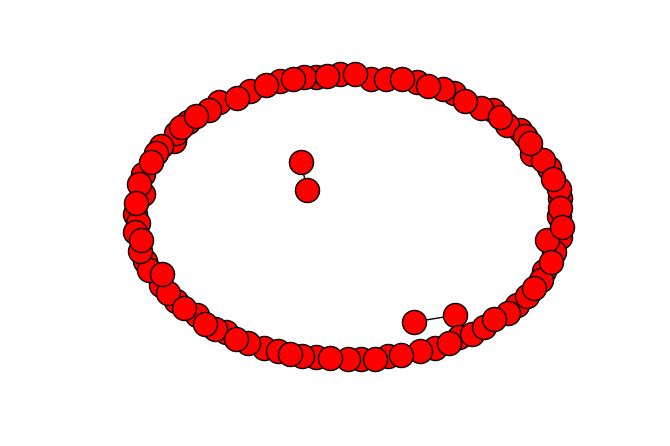

In [35]:
%matplotlib inline
nx.draw(g)
plt.show()

Grafo desarrollado en Neo4j

In [326]:
file = open('C:\\Users\\Alberto\\PycharmProjects\\twitterExtraction\\CarmenaTweets_Test.txt','r')
decoded = ''
counter = 0
graph  = Graph("http://localhost:7474/db/data/",user='neo4j',password='ingamc03')
for line in file: 
    try:
        decoded = json.loads(line)
    except Exception as e:
        print e,':',decoded['id'] 
        
    try:
        user = processUser(decoded, dfusers)
    except Exception as a:
        print a.args,':','error processing users'
        
    try:
        tw = processTweet(decoded,dftweets)
    except Exception as a:
        print a.args,':','error processing tweet'
        
    try:
        create_relationship(tw,graph)
    except Exception as a:
        print a.args,':','creating node and relationship'
        
    

NAME:SenioritoLuShin
DESC:ateo. nihilista. republicano (no monarquico), un poco feminista
FOLLOWERS:87
FOLLOWING:None
Procesaudo el publisher.....
NAME:SenioritoLuShin
DESC:ateo. nihilista. republicano (no monarquico), un poco feminista
FOLLOWERS:87
FOLLOWING:None
Procesado....
("'unicode' object has no attribute 'name'",) : creating node and relationship
NAME:biferato
DESC:Podemos cambiar España, está en nuestras manos
FOLLOWERS:71
FOLLOWING:None
Procesaudo el publisher.....
NAME:biferato
DESC:Podemos cambiar España, está en nuestras manos
FOLLOWERS:71
FOLLOWING:None
Procesado....
("'unicode' object has no attribute 'name'",) : creating node and relationship
NAME:patxi7045
("cannot concatenate 'str' and 'NoneType' objects",) : error processing User......
("local variable 'us' referenced before assignment",) : error processing users
Procesaudo el publisher.....
NAME:patxi7045
("cannot concatenate 'str' and 'NoneType' objects",) : error processing User......
("local variable 'us' refere

In [17]:
dfusers = pd.DataFrame(columns=['name','description','url','followers','lang','profile_image','following','followers'])
dftweets = pd.DataFrame(columns=['userId','geo','coordinates','timestamp','tweet','source','isretweeted','lang','lat','lon','polarity'])

In [5]:
dfusers.head(2)

,Unnamed: 0,name,location,url,followers,lang,profile_image,following
0,799032032017993733,GRUPO METRO MENDOZA,"Mendoza, Argentina",http://www.grupometromza.com,24.0,es,http://pbs.twimg.com/profile_images/7990356908...,NaN
1,2326149346,Pepe López,NaN,NaN,329.0,es,http://pbs.twimg.com/profile_images/4310926238...,NaN
